In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from kuma_utils.utils import sigmoid
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge

from datasets import *
from transforms import *
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
valid = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v23v.csv')
public748 = pd.read_csv('input/public748.csv')
iafoss_v5160 = {
    'oof': pd.read_csv('input/predictions/0.758_v5_1_6_0_val.csv'),
    'pred': pd.read_csv('input/predictions/0.758_v5_1_6_0_submission.csv')}
# iafoss_v5210 = {
#     'oof': pd.read_csv('input/predictions/val_model_v5_2_1_0.csv'),
#     'pred': pd.read_csv('input/predictions/submission_model_v5_2_1_0.csv')}
iafoss_v7000 = {
    'oof': pd.read_csv('input/predictions/0.756_v7_0_0_0_val.csv'),
    'pred': pd.read_csv('input/predictions/0.756_v7_0_0_0_submission.csv')}
iafoss_v8000 = {
    'oof': pd.read_csv('input/predictions/0.758_v8_0_0_0c_val.csv'),
    'pred': pd.read_csv('input/predictions/0.758_v8_0_0_0c_submission.csv')}
# chris_v16 = {
#     'oof': pd.read_csv('input/predictions/valset_16_0.7036.csv'),
#     'pred': pd.read_csv('input/predictions/sub_16_bce_mse.csv')}
# chris_v18 = {
#     'oof': pd.read_csv('input/predictions/valset_18_0.6997.csv'),
#     'pred': pd.read_csv('input/predictions/sub_18_double_model.csv')}
# drhb_exp200 = {
#     'oof': pd.read_csv('input/predictions/EXP_200_BASELINE_CASHE_V4_EVAL_V23_CORRECT.csv', usecols=['id', 'pred']),
#     'pred': pd.read_csv('input/predictions/EXP_200_BASELINE_CASHE_V4.csv')}
drhb_tsv1 = {
    'oof': pd.read_csv('input/predictions/TIME_SYNC_V1_CONVNEXT_144_OOF.csv'),
    'pred': pd.read_csv('input/predictions/TIME_SYNC_V1_CONVNEXT_144.csv')}

In [4]:
valid['is_generated_noise'] = 1 - valid[['nonstationary_H1', 'nonstationary_L1']].max(1)

In [14]:
model_paths = [
    # Path('results/ds_09_val0'),
    # Path('results/ds_09_val1'),
    # Path('results/aug_04'),
    # # Path('results/ds_14'),
    # # Path('results/ds_15'),
    # # Path('results/ds_16'),
    # # Path('results/model_02'),
    # Path('results/ds_14_prep2'),
    # Path('results/ds_17_prep2'),
    # Path('results/ds_18_prep3'),
    # Path('results/ds_18_prep7'),
    # Path('results/ds_18_lf0'),
    # Path('results/ds_19'),
    # Path('results/ds_19_prep0'),
    Path('results/ds_19_res0'),
    Path('results/ds_19_prep0_l'),
    Path('results/ds_18_res1'),
    # Path('results/ds_18_res2'),
    # Path('results/model_03'),
    # Path('results/model_04'),
    Path('results/model_04_prep0'),
    Path('results/ds_20_l'),
    Path('results/ds_21'),
]


In [15]:
prediction_df = {}
oof_df = {}
for p in model_paths:
    pred = sigmoid(np.load(p/'predictions_tta.npy'))
    oof = sigmoid(np.load(p/'outoffolds_tta.npy'))
    prediction_df[p.stem] = pred.reshape(-1)
    oof_df[p.stem] = oof.reshape(-1)
    pd.DataFrame({'id': valid['id'], 'target': oof.reshape(-1)}).to_csv(f'input/predictions/kuma/{p.stem}_oof_v23.csv', index=False)
    pd.DataFrame({'id': test['id'], 'target': pred.reshape(-1)}).to_csv(f'input/predictions/kuma/{p.stem}_prediction.csv', index=False)


prediction_df = pd.DataFrame(prediction_df)
prediction_df['id'] = test['id']
# prediction_df['iafoss_v5160'] = iafoss_v5160['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['iafoss_v5210'] = iafoss_v5210['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['iafoss_v7000'] = iafoss_v7000['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['drhb_exp200'] = drhb_exp200['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['chris_v16'] = chris_v16['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['chris_v18'] = chris_v18['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['iafoss_v7000'] = iafoss_v7000['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['iafoss_v8000'] = iafoss_v8000['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
prediction_df['drhb_tsv1'] = drhb_tsv1['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
oof_df = pd.DataFrame(oof_df)
oof_df['id'] = valid['id']
# oof_df['iafoss_v5160'] = iafoss_v5160['oof']['target']
# oof_df['iafoss_v5210'] = iafoss_v5210['oof']['target']
# oof_df['iafoss_v7000'] = iafoss_v7000['oof']['target']
# oof_df['drhb_exp200'] = drhb_exp200['oof']['pred']
# oof_df['chris_v16'] = chris_v16['oof']['target']
# oof_df['chris_v18'] = chris_v18['oof']['target']
# oof_df['iafoss_v7000'] = iafoss_v7000['oof']['target']
# oof_df['iafoss_v8000'] = iafoss_v8000['oof']['target']
oof_df['drhb_tsv1'] = drhb_tsv1['oof']['target']

In [16]:
oof_df['target'] = valid['target']
oof_df.dropna(inplace=True)
oof_df = oof_df.merge(valid[['id', 'is_generated_noise']], on='id', how='left')

In [17]:
valid['id'] = valid['id'].str[:-4]
prediction_df = prediction_df.merge(valid[['id', 'is_generated_noise']], on='id', how='left')

In [18]:
oof_df

,ds_19_res0,ds_19_prep0_l,ds_18_res1,model_04_prep0,ds_20_l,ds_21,id,drhb_tsv1,target,is_generated_noise
0,0.452937,0.425105,0.464025,0.437778,0.441975,0.454503,00054c878,0.456582,0,1
1,0.447089,0.480884,0.468055,0.456406,0.484763,0.538511,0007285a3,0.466196,1,1
2,0.509641,0.546803,0.510176,0.526541,0.573106,0.564461,00076c5a6,0.514707,0,1
3,0.999999,0.999998,0.999894,1.000000,0.999998,1.000000,001349290,0.999992,1,1
4,0.495830,0.438807,0.445968,0.401344,0.459077,0.502522,001a52e92,0.435779,0,1
...,...,...,...,...,...,...,...,...,...,...
7966,0.529053,0.510158,0.463375,0.477344,0.721970,0.925343,ff85bd962,0.999991,1,1
7967,0.504600,0.461800,0.480481,0.475264,0.483547,0.455117,ff8ec13f7,0.515491,0,1
7968,0.960677,0.994815,0.983793,0.995496,0.969021,0.952675,ff9831d8b,0.397687,1,1
7969,0.427482,0.452594,0.451431,0.464949,0.460882,0.440391,ffb5b60b1,0.999981,0,1


In [19]:
prediction_df

,ds_19_res0,ds_19_prep0_l,ds_18_res1,model_04_prep0,ds_20_l,ds_21,id,drhb_tsv1,is_generated_noise
0,0.425995,0.434326,0.420984,0.406273,0.461013,0.496339,00054c878,0.503501,NaN
1,0.988217,0.999847,0.976005,0.996886,0.999787,0.938137,0007285a3,0.989127,NaN
2,0.433817,0.397333,0.420322,0.412385,0.420734,0.402411,00076c5a6,0.395174,NaN
3,0.741243,0.817488,0.725946,0.865758,0.877902,0.918099,001349290,0.936551,NaN
4,0.721682,0.975088,0.778745,0.971427,0.977508,0.988429,001a52e92,0.993722,NaN
...,...,...,...,...,...,...,...,...,...
7970,0.999943,1.000000,0.999963,0.999788,0.999994,0.999888,ffbce04ef,0.999991,NaN
7971,0.476624,0.518646,0.535959,0.508597,0.496891,0.472662,ffc2d976b,0.659682,NaN
7972,0.463550,0.446654,0.447993,0.413761,0.443995,0.447117,ffc905909,0.431866,NaN
7973,0.493132,0.428251,0.459954,0.444436,0.429917,0.390647,ffe276f3e,0.444832,NaN


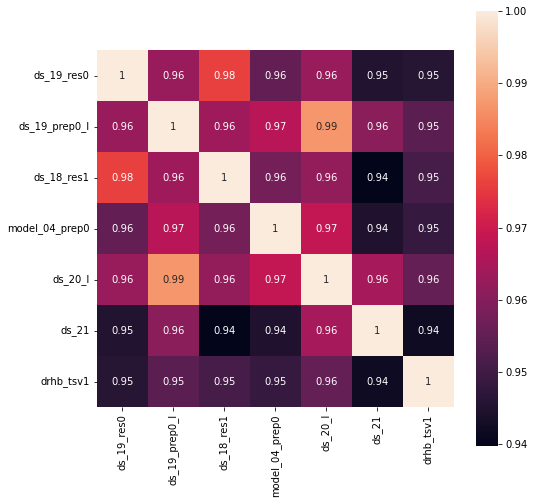

In [20]:
plt.figure(figsize=(8, 8))
sns.heatmap(prediction_df.drop('is_generated_noise', axis=1).corr(), square=True, annot=True)
plt.show()

In [30]:
model = Ridge(positive=True)
X = oof_df.drop(['target', 'id', 'is_generated_noise'], axis=1)
y = oof_df['target']
X_test = prediction_df.drop(['id', 'is_generated_noise'], axis=1)
model.fit(X, y)
y_pred = model.predict(X)
y_stack = model.predict(X_test)
print('stacking cv', roc_auc_score(y, y_pred))
print('weight', model.coef_)

stacking cv 0.7891950246222964
weight [0.24474786 0.25769368 0.24227017 0.26500817 0.04231313]


In [31]:
y_stack

array([0.42465206, 1.01951666, 0.41390951, ..., 0.4425171 , 0.45659086,
       0.44231182])

In [32]:
# test['target'] = prediction_df['model_03']
test['target'] = y_stack

In [33]:
test

,id,target
0,00054c878,0.424652
1,0007285a3,1.019517
2,00076c5a6,0.413910
3,001349290,0.814521
4,001a52e92,0.893560
...,...,...
7970,ffbce04ef,1.029459
7971,ffc2d976b,0.520352
7972,ffc905909,0.442517
7973,ffe276f3e,0.456591


In [16]:
oof_df

,ds_19,ds_19_prep0,ds_18_res1,model_03,model_04,model_04_prep0,id,iafoss_v8000,drhb_tsv1,target,is_generated_noise
0,0.437987,0.417616,0.464025,0.469050,0.450539,0.437778,00054c878_gen,0.484375,0.456582,0,1
1,0.481549,0.469458,0.468055,0.518737,0.503169,0.456406,0007285a3_gen,0.525391,0.466196,1,1
2,0.537548,0.544146,0.510176,0.531273,0.546493,0.526541,00076c5a6_gen,0.560059,0.514707,0,1
3,1.000000,0.999980,0.999894,0.999999,1.000000,1.000000,001349290_gen,0.987793,0.999992,1,1
4,0.452154,0.448764,0.445968,0.430400,0.411340,0.401344,001a52e92_gen,0.454834,0.435779,0,1
...,...,...,...,...,...,...,...,...,...,...,...
7966,0.436019,0.465031,0.463375,0.581896,0.523412,0.477344,ff85bd962_gen,0.741699,0.999991,1,1
7967,0.470437,0.469997,0.480481,0.492642,0.463440,0.475264,ff8ec13f7_gen,0.556152,0.515491,0,1
7968,0.983742,0.965069,0.983793,0.989809,0.999207,0.995496,ff9831d8b_gen,0.711426,0.397687,1,1
7969,0.470455,0.445383,0.451431,0.599857,0.539379,0.464949,ffb5b60b1_gen,0.455322,0.999981,0,1


In [34]:
X.columns

Index(['ds_19_res0', 'ds_19_prep0_l', 'ds_18_res1', 'model_04_prep0',
       'drhb_tsv1'],
      dtype='object')

In [35]:
name = '_'.join(X.columns)

In [36]:
test.to_csv(f'results/stacking_{name}.csv', index=False)
# test.to_csv(Path('results/model_03')/'submission.csv', index=False)

# Trad blending

In [38]:
blend_df = dict(
    # COMB7=pd.read_csv('input/predictions/COMB_7.csv')['target'], # LB 0.771
    # stacking_res=y_stack, # stack with only my model cv 0.739
    # drhb_exp200=prediction_df['drhb_exp200'], # LB 0.754 (add because it has no CV/LB corr)
    # iafoss_5160=prediction_df['iafoss_v5160'], # LB 0.758
    # iafoss_5210=prediction_df['iafoss_v5210'], # LB 0.757
    # public761=pd.read_csv('input/public761.csv')['target']
    # COMB13_RB=pd.read_csv('input/predictions/COMB_13_REAL_BLENDING_0.4_0.6.csv').merge(test['id'], on='id', how='right')['target'],
    # ds_17_prep2=pd.read_csv('results/ds_17_prep2/submission.csv').merge(test['id'], on='id', how='right')['target'],
    # ds_17_prep1=pd.read_csv('results/ds_17_prep1_beforefix/submission.csv').merge(test['id'], on='id', how='right')['target'],
    # ds_18_prep3=pd.read_csv('results/ds_18_prep3/submission.csv').merge(test['id'], on='id', how='right')['target'],
    # ds_18_prep7=pd.read_csv('results/ds_18_prep7/submission.csv').merge(test['id'], on='id', how='right')['target'],
    blend_comb13rb_ds17prep2=pd.read_csv('results/blend_comb13rb_ds17prep2.csv')['target'],
    # stacking_776=pd.read_csv('results/stacking_ds_19_ds_19_prep0_ds_18_res1_model_03_model_04_model_04_prep0_iafoss_v8000_drhb_tsv1.csv')['target'],
    stacking_777=pd.read_csv('results/stacking_ds_19_ds_19_prep0_model_03_drhb_exp200_iafoss_v8000.csv')['target'],
    drhb_tsv1=pd.read_csv('input/predictions/TIME_SYNC_V1_CONVNEXT_144.csv')['target']
)
blend_df = pd.DataFrame(blend_df)
blend_df = blend_df.rank(axis=0)
blend_df = blend_df / blend_df.max(axis=0).values[None, :]

In [39]:
blend_df.corr()

,blend_comb13rb_ds17prep2,stacking_777,drhb_tsv1
blend_comb13rb_ds17prep2,1.000000,0.877236,0.841898
stacking_777,0.877236,1.000000,0.906092
drhb_tsv1,0.841898,0.906092,1.000000


In [40]:
blend_df['target'] = \
    blend_df['blend_comb13rb_ds17prep2'] * 0.7 + blend_df['stacking_777'] * 0.2 + blend_df['drhb_tsv1'] * 0.1

In [24]:
test['target'] = blend_df['target']
test.to_csv(Path('results/blend_(blend_comb13rb_ds17prep2)_(stacking_777)_(drhb_tsv1).csv'), index=False)